In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 2
from src.folder_handler import *
from src.cort_processor import *
from src.cca_processor import *
from src.tdt_support import *
from src.plotter import *
from src.decoders import *
from src.utils import *
import pickle
import scipy as sio
import numpy as np
import matplotlib.pyplot as plt
from  matplotlib.colors import LinearSegmentedColormap
from src.wiener_filter import *
from matplotlib.pyplot import cm
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
import os
import copy

# load pre-SCI as CP1, post-sci at CP2

In [2]:
with open('/home/diya/Documents/rat-fes/data/pickles/3-meepo_regular_923__session.pkl', 'rb') as inp: #YOUR PATH HERE
    cp1 = pickle.load(inp)
    
with open('/home/diya/Documents/rat-fes/data/pickles/3-results-injured-meepolemons1004_meepo_session.pkl', 'rb') as inp: #YOUR PATH HERE
    cp2 = pickle.load(inp)

# comparing forelimb kinematics pre and post sci

Text(0, 0.5, 'degrees')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
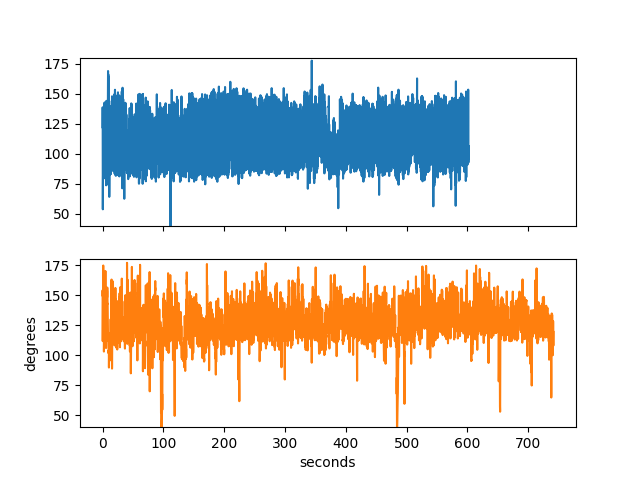

In [3]:
cp1_forelimb = np.vstack(cp1.data['angles'])[:,6]
cp2_forelimb = np.vstack(cp2.data['angles'])[:,6]

fig0 , (ax01, ax02) = plt.subplots(2,1, sharex=True)
cp1_samples = cp1_forelimb.shape[0]
cp1_ts = np.linspace(0, (cp1_samples*50)/1000, cp1_samples)
ax01.plot(cp1_ts, cp1_forelimb)
ax01.set_ylim(bottom=40, top=180)
cp2_samples = cp2_forelimb.shape[0]
cp2_ts = np.linspace(0, (cp2_samples*50)/1000, cp2_samples)
ax02.plot(cp2_ts, cp2_forelimb, color='tab:orange')
ax02.set_ylim(bottom=40, top=180)

ax02.set_xlabel('seconds')
ax02.set_ylabel('degrees')

# decoding forelimb just with wiener filter
adding PCA doesn't help either

0.3470000000000001
-0.005
num dims_27.0, vaf=-0.002


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
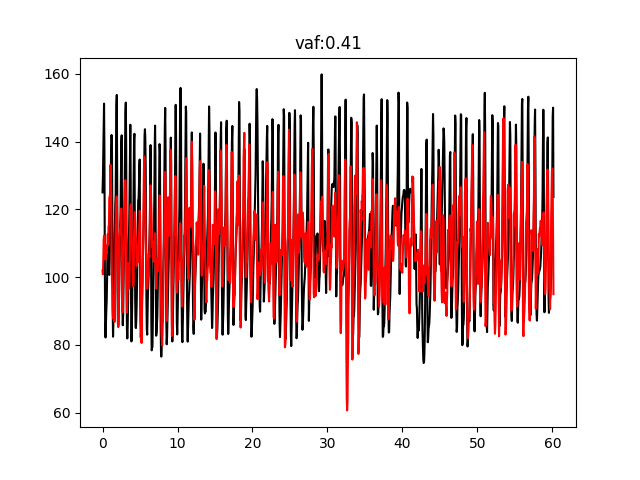

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
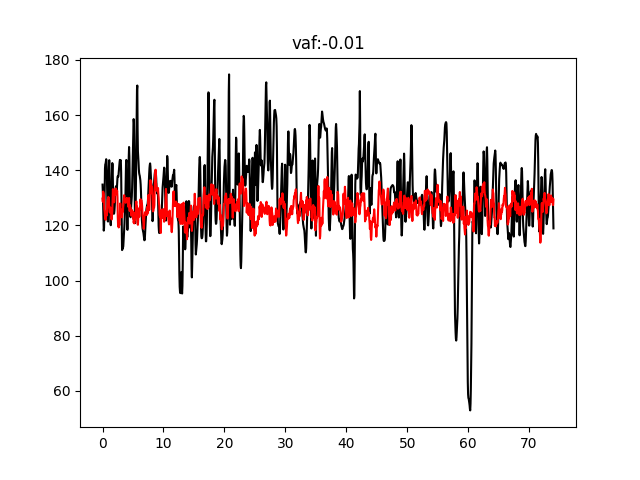

In [4]:
cp1_h, cp1_vaf, cp1_testx, cp1_testy = cp1.decode_angles()
cp2_h, cp2_vaf, cp2_testx, cp2_testy = cp2.decode_angles()

plot_wiener_filter_predic(cp1_testx, cp1_testy[:,6], cp1_h[:,6])
plot_wiener_filter_predic(cp2_testx, cp2_testy[:,6], cp2_h[:,6])
print(np.average(cp1_vaf, 1)[6])
print(np.average(cp2_vaf, 1)[6])

nada, cp2_pca_vaf, nadax, nada = cp2.decode_angles(X=cp2.apply_PCA())
temp = np.average(cp2_pca_vaf,1)[6]
print(f'num dims_{nadax.shape[1]/10}, vaf={temp}')

# lets try aligning pre and post SCI forelimb

In [5]:
my_cca = CCAProcessor(cp1, cp2, limbfoot_angle=6, align=0)

(6084,)
(5964,)
(4083,)
(5464,)
(5284,)
should be good to align
(1450, 32)
(1450, 7)
(1450, 32)
(1450, 7)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
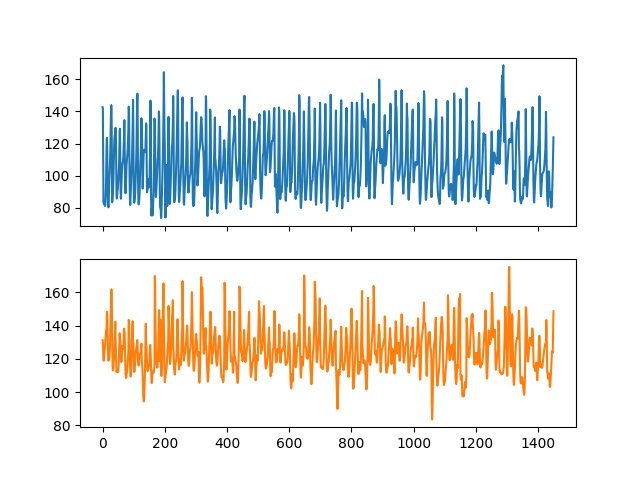

In [6]:
cp1_forelimb_aligned = my_cca.data['cp1']['proc_y'][:,6]
cp2_forelimb_aligned = my_cca.data['cp2']['proc_y'][:,6]

fig1, (ax11, ax12) = plt.subplots(2,1, sharex=True)
ax11.plot(cp1_forelimb_aligned)
ax12.plot(cp2_forelimb_aligned, color='tab:orange')

# training alignment decoder

dim0 corr is 0.28
dim1 corr is 0.26
dim2 corr is 0.25
(1450, 32) (1450, 7)
initial_scoring is : -0.07
new_scoring is: 0.26
0.24


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
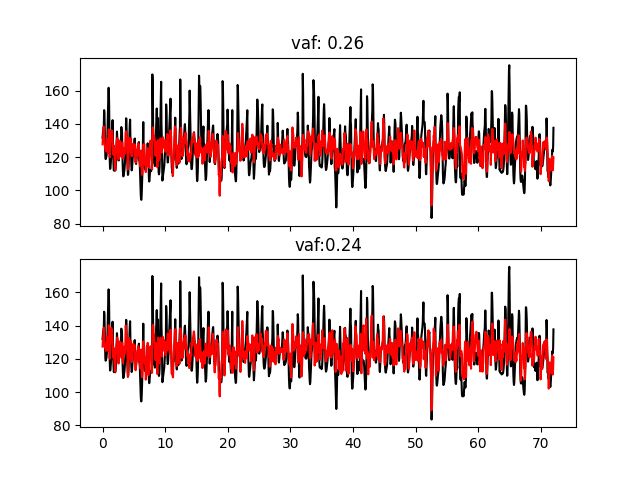

In [7]:
transformer, wpost, ywpost = my_cca.apply_ridge_only_proc()

proc_x = my_cca.data['cp2']['proc_x']
proc_y = my_cca.data['cp2']['proc_y']

proc_x_format, proc_y_format = format_data(proc_x, proc_y)
ywpost_adjusted = ywpost + (np.mean(proc_y_format[:,6]) - np.mean(ywpost[:,6]))
aligner_vaf = vaf(proc_y_format[:,6], ywpost[:,6])

wiener_h, nada, nada, nada = cp2.decode_angles([proc_x], [proc_y])
wiener_predic = test_wiener_filter(proc_x_format, wiener_h)
wiener_vaf = vaf(proc_y_format[:,6], wiener_predic[:,6])

fig3, (ax31, ax32) = plt.subplots(2, 1, sharex=True)

proc_samples = proc_x_format.shape[0]
proc_ts = np.linspace(0, (proc_samples*50)/1000, proc_samples)

ax31.plot(proc_ts, proc_y_format[:,6], color='black')
ax31.plot(proc_ts, ywpost_adjusted[:,6], color='red')

ax32.plot(proc_ts, proc_y_format[:,6], color='black')
ax32.plot(proc_ts, wiener_predic[:,6], color='red')
ax31.set_title(f'vaf: {aligner_vaf}')
ax32.set_title(f'vaf:{wiener_vaf}')


print(wiener_vaf)

dim0 corr is 0.28
dim1 corr is 0.26
dim2 corr is 0.25
initial_scoring is : -0.08
new_scoring is: 0.06


Text(0.5, 1.0, 'vaf: 0.06')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
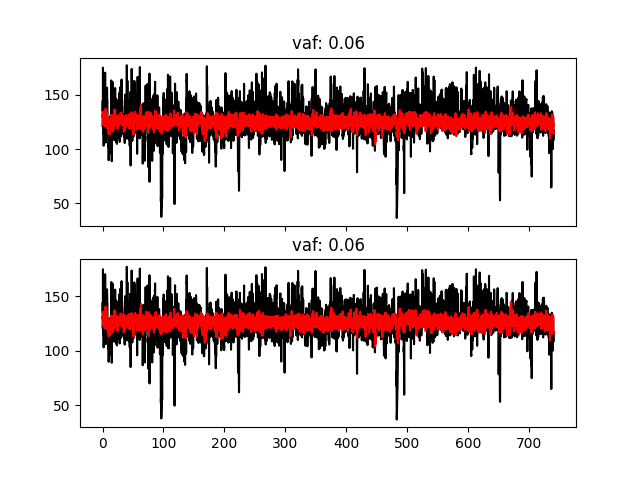

In [8]:
transformer, wpost, ywpost = my_cca.apply_ridge()

proc_x = my_cca.data['cp2']['proc_x']
proc_y = my_cca.data['cp2']['proc_y']

full_x = cp2.data['rates']
full_y = cp2.data['angles']

full_x_format, full_y_format = cp2.stitch_and_format(full_x, full_y)
proc_x_format, proc_y_format = format_data(proc_x, proc_y)
ywpost_adjusted = ywpost + (np.mean(proc_y_format[:,6]) - np.mean(ywpost[:,6]))
vaf_aligned_only = vaf(full_y_format[:,6], ywpost[:,6])

wiener_predic_full = test_wiener_filter(full_x_format, cp2_h)
vaf_wiener_full = vaf(full_y_format[:,6], wiener_predic_full[:,6])


figgy, (ax41, ax42) = plt.subplots(2,1,sharex=True)

full_samples = full_x_format.shape[0]
full_ts = np.linspace(0, (full_samples*50)/1000, full_samples)

ax41.plot(full_ts, full_y_format[:,6], color='black')
ax41.plot(full_ts, ywpost_adjusted[:,6], color='red')
ax41.set_title(f'vaf: {vaf_aligned_only}')

ax42.plot(full_ts, full_y_format[:,6], color='black')
ax42.plot(full_ts, wiener_predic_full[:,6], color='red')
ax42.set_title(f'vaf: {vaf_wiener_full}')


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
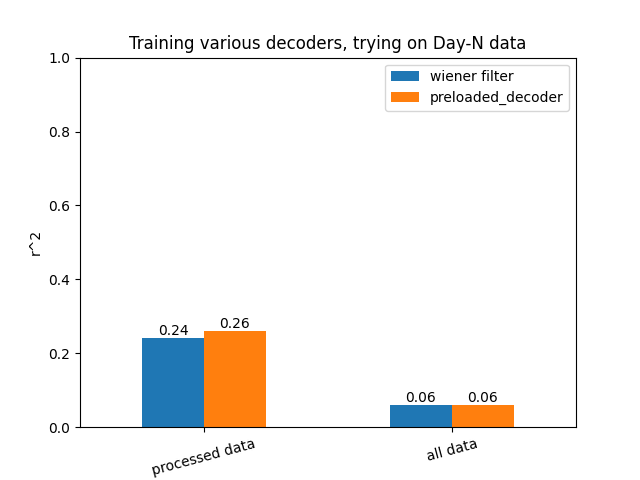

In [10]:
preload_data = []
wiener_data = []

preload_data.extend((aligner_vaf, vaf_aligned_only))
wiener_data.extend((wiener_vaf, vaf_wiener_full))

plot_dict = {}
plot_dict['wiener filter'] = wiener_data
plot_dict['preloaded_decoder'] = preload_data
index = ['processed data', 'all data']

df = pd.DataFrame(data=plot_dict, index=index)

  
# plot grouped bar chart
ax = df.plot.bar(rot=15)
ax.set_ylim(bottom=-1, top=1)
ax.set_title('Training various decoders, trying on Day-N data')
ax.set_ylabel('r^2')
ax.set_ylim(bottom=0)
ax.set_xlabel('percent of total day-n data')
ax.legend(loc='upper right')
for container in ax.containers:
    ax.bar_label(container)

# applying trained decoder to entire SCI dataset  

Text(0.5, 1.0, '0.06')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
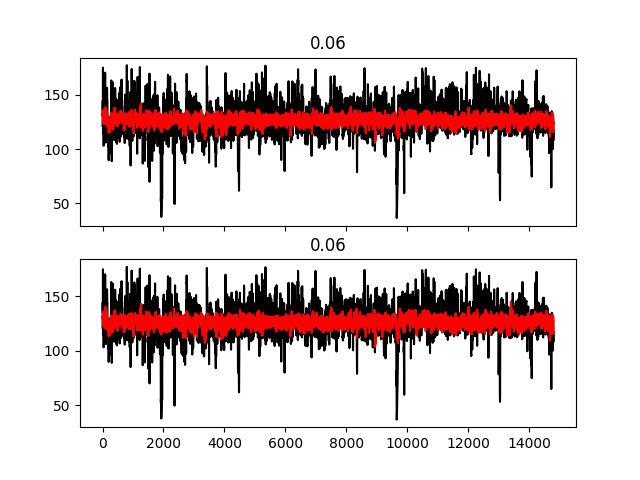

In [11]:
scaler = StandardScaler() 
full_x = cp2.data['rates']
full_y = cp2.data['angles']

aligned_full_x = []
scaler.fit(np.vstack(full_x))
for x in full_x:
    temp_x = scaler.transform(x)
    aligned_full_x.append(my_cca.quick_cca(temp_x, transformer))

aligned_full_x_format, full_y_format = cp2.stitch_and_format(aligned_full_x, full_y)
full_x_format, nada = cp2.stitch_and_format(full_x, full_y)

full_predic = test_wiener_filter(aligned_full_x_format, wpost)
full_predic_adjusted = full_predic + (np.mean(full_y_format[:,6]) - np.mean(full_predic[:,6]))
#plot_wiener_filter_predic(aligned_full_x_format, full_y_format[:,6], wpost[:,6]) 

full_predic_wiener = test_wiener_filter(full_x_format, cp2_h)

full_vaf = vaf(full_y_format[:,6], full_predic[:,6])
full_vaf_wiener = vaf(full_y_format[:,6], full_predic_wiener[:,6])

fig2, (ax21, ax22) = plt.subplots(2,1, sharex=True)
ax21.plot(full_y_format[:,6], color='black')
ax21.plot(full_predic_adjusted[:,6], color='red')
ax21.set_title(full_vaf)

ax22.plot(full_y_format[:,6], color='black')
ax22.plot(full_predic_wiener[:,6], color='red')
ax22.set_title(full_vaf_wiener)



ValueError: operands could not be broadcast together with shapes (1440,) (14801,) 

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
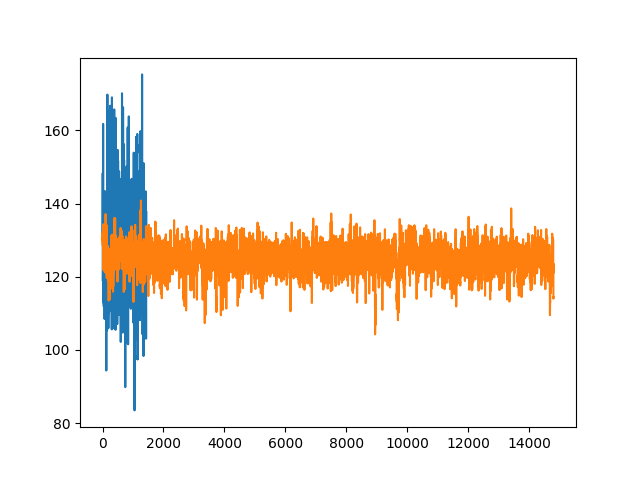

In [12]:
fig, ax = plt.subplots()
ax.plot(proc_y_format[:,6])
ax.plot(ywpost_adjusted[:,6])

print(vaf(proc_y_format[:,6], ywpost_adjusted[:,6]))



In [10]:
aligned_raw_x_format, raw_y_format = my_cca.cp2.stitch_and_format(aligned_raw_x, raw_y)

NameError: name 'aligned_raw_x' is not defined

In [ ]:
predic = test_wiener_filter(aligned_raw_x_format, wpost)
fig, ax = plt.subplots()
predic_adjusted = predic + (np.mean(raw_y_format[:,6]) - np.mean(predic[:,6]))
ax.plot(raw_y_format[:,6])
ax.plot(predic_adjusted[:,6])

print(vaf(raw_y_format[:,6], predic_adjusted[:,6]))

In [ ]:
kin1 = my_cca.data['cp1']['proc_y']
kin2 = my_cca.data['cp2']['proc_y']

In [ ]:
fig, ax=plt.subplots()
ax.plot(kin1[:,6])
ax.plot(kin2[:,6])

In [ ]:
diya.shape

In [ ]:
diya_format, y_format = format_data(diya, kin2)

In [ ]:
predic = test_wiener_filter(diya_format, h)


In [ ]:
fig, ax = plt.subplots()
ax.plot(y_format[:,6])
ax.plot(predic[:,6])